## **NAMA: Sharon Zefanya Setiawan**
## **NIM: 2501961022**
## **KELAS: LA09**

### 1. Konsep sains data sebagai bidang studi sendiri diajukan oleh William S. Cleveland. Dia memperluas ilmu statistik ke area teknis, yang akan merubah bidang ini secara signifikan. Dia diminta untuk membuat sebuah aplikasi yang membantu perusahaan untuk memprediksi harga saham.

### Dalam dataset yang disediakan terdapat informasi penting mengenai keterangan setiap kolomnya. Yang akan digunakan kolom **Date dan Close** saja. Buatlah arsitektur Long Short Term Memory (LSTM). Berikut adalah ketentuan yang perlu diperhatikan dalam pembuatan arsitektur LSTM.

**DATASET B**

Dataset ini berisi harga harian historis untuk beberapa saham sektor teknologi:

1.   Amazon.com, Inc (AMZN)
2.   Cisco Systems, Inc (CSCO)



#### a. Lakukan **eksplorasi data** terlebih dahulu untuk memahami permasalahan yang dihadapi terlebih dahulu. Dataset yang diberikan adalah data time series, lakukan **praproses data** untuk menyelesaikan problem dari data tersebut. **Pisahkan data *time series* tersebut menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan horizon = 1 [hari senin saja].** Selanjutnya pisahkan dataset menjadi train, test dan validation set dengan ketentuan (80 train, 10 val, 10 test).

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests

from keras import Model
from tensorflow.keras.layers import Flatten, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime

##### **AMAZON DATASET**

In [ ]:
# read data
df_amzn = pd.read_csv('https://raw.githubusercontent.com/sharonzefanyaa/UAS-deeplearn/main/Dataset%20B/AMZN.csv',
                      parse_dates=["Date"],
                      index_col=["Date"])
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [ ]:
df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5758 entries, 1997-05-15 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5758 non-null   float64
 1   High       5758 non-null   float64
 2   Low        5758 non-null   float64
 3   Close      5758 non-null   float64
 4   Adj Close  5758 non-null   float64
 5   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 314.9 KB


In [ ]:
df_amzn.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5.758000e+03
mean,340.458153,344.156408,336.344390,340.417580,340.417580,7.556094e+06
std,523.365374,528.138556,517.726971,523.140207,523.140207,7.325904e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.460001,38.334999,36.812499,37.562500,37.562500,3.685525e+06
50%,81.965000,83.520000,79.875000,81.599998,81.599998,5.692450e+06
75%,335.267494,337.537491,331.727501,334.290001,334.290001,8.594350e+06
max,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,1.043292e+08


In [ ]:
df_amzn.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_amzn.duplicated().sum()

0

<ipython-input-203-7e6e3afe19e7>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_amzn[df_amzn.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
<ipython-input-203-7e6e3afe19e7>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_amzn[df_amzn.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
<ipython-input-203-7e6e3afe19e7>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_amzn[df_amzn.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
<ipython-input-203-7e6e3afe19e7>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill

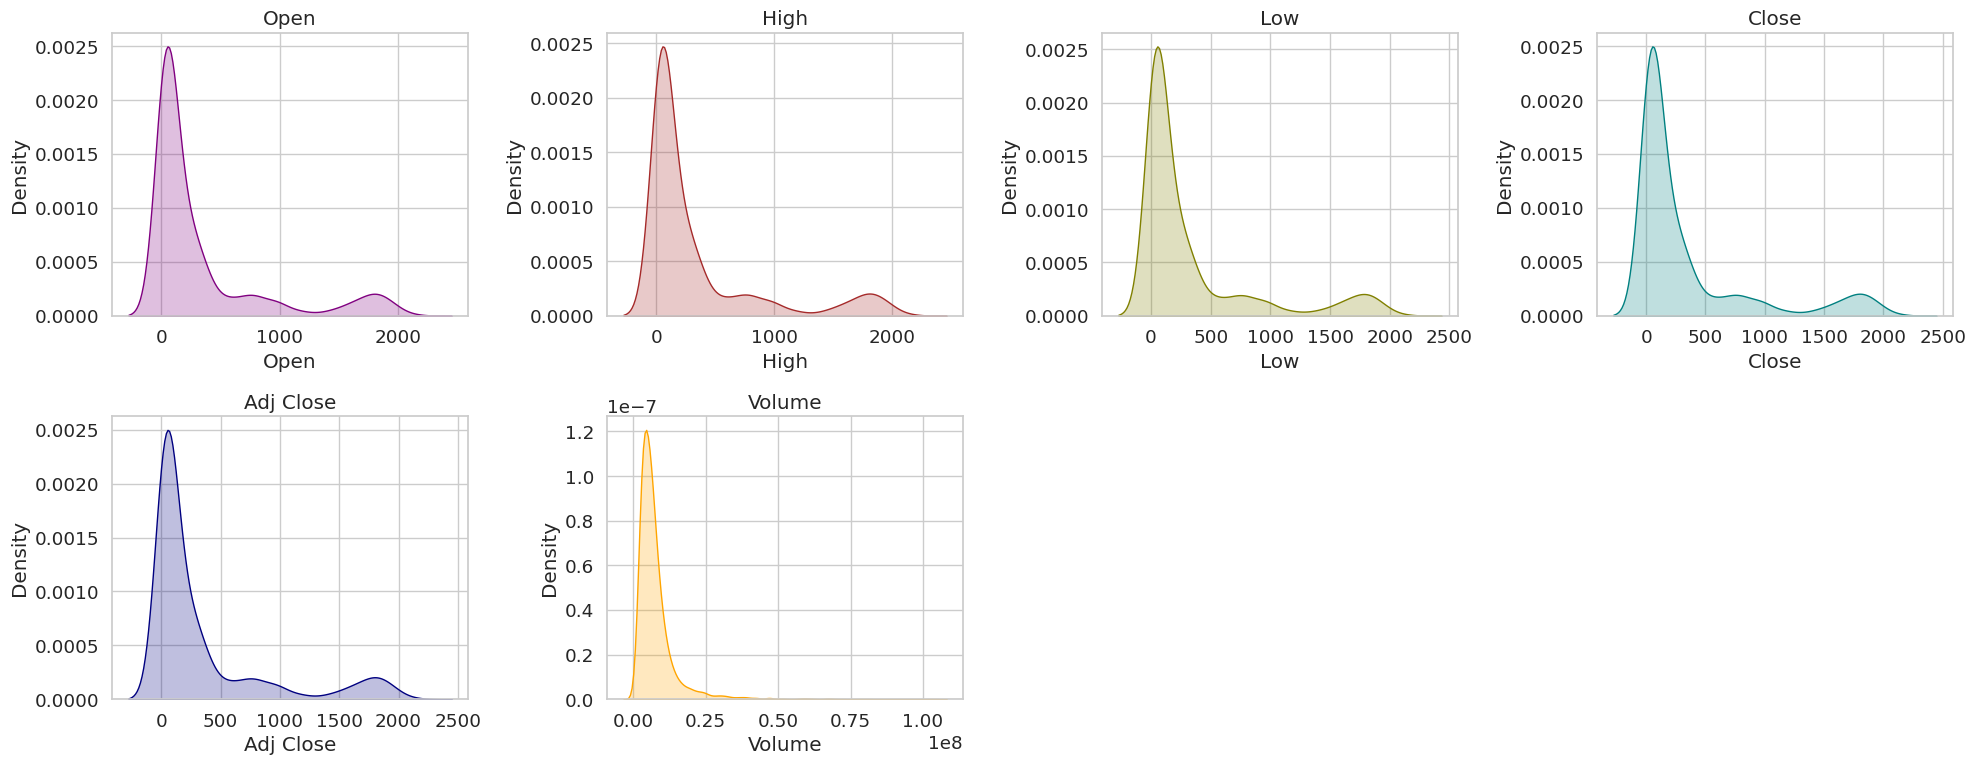

In [ ]:
# plot density plots using seaborn
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

num_cols = len(df_amzn.columns)
num_rows = num_cols // 4 + 1
colors = ['purple', 'brown', 'olive', 'teal', 'navy', 'orange']

for i in range(num_cols):
    row = i // 4
    col = i % 4
    sns.kdeplot(data=df_amzn[df_amzn.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
    axes[row, col].set_title(df_amzn.columns[i])

# Remove empty subplots if there are any
if num_cols < 16:
    for j in range(num_cols, 16):
        row = j // 4
        col = j % 4
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

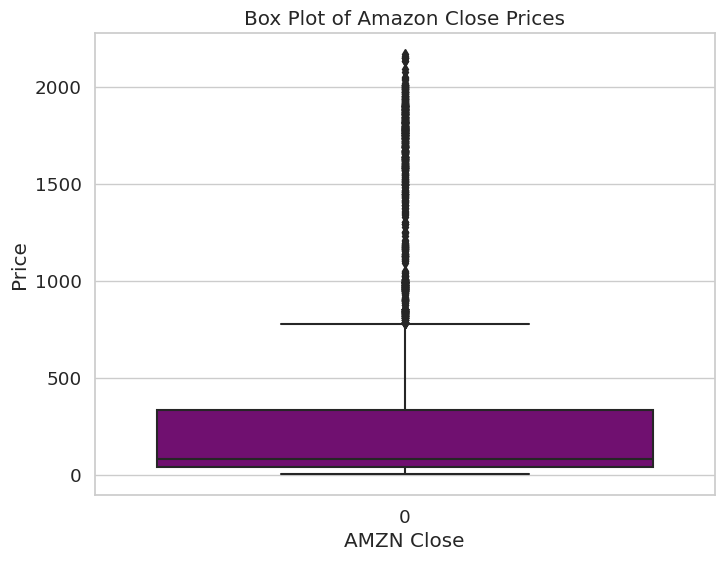

In [ ]:
# univariate analysis
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_amzn['Close'], color='purple')

plt.xlabel('AMZN Close')
plt.ylabel('Price')
plt.title('Box Plot of Amazon Close Prices')

plt.show()


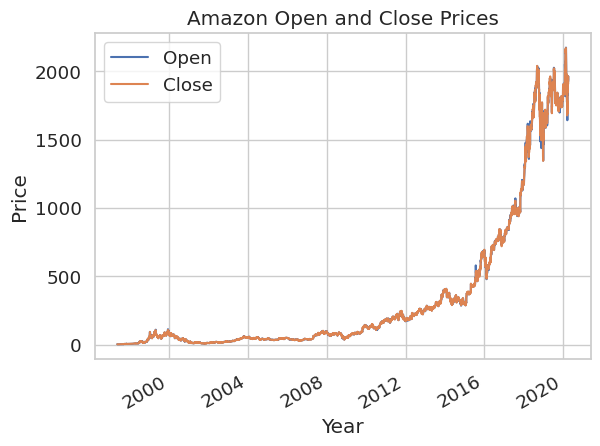

In [ ]:
# multivariate analysis
df_amzn[['Open', 'Close']].plot.line()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Amazon Open and Close Prices')
plt.legend(['Open', 'Close'])
plt.show()

Dari hasil eksplorasi data sekilas di atas, diketahui bahwa data sudah siap untuk diproses lebih lanjut. Sebelumnya, atribut 'Date' sudah diubah menjadi index dengan format data datetime, tidak ada missing value maupun duplikasi data yang mencurigakan.

Berdasarkan hasil density plot, diketahui pula bahwa data tersebut bersifat skew ke kiri *(skewed left)* yang mengindikasikan bahwa ekor atau nilai-nilai yang rendah dari distribusi data lebih panjang atau lebih jarang terjadi dibandingkan dengan nilai-nilai yang tinggi. Selain itu, pada boxplot 'Close' didapati bahwa ada banyak outlier. Namun, outlier hanya akan mempengaruhi model statistik seperti regresi, sehingga diasumsikan bahwa semua ini tidak berdampak besar pada pemrosesan dan dapat dilanjutkan dengan membuat dataframe baru yang difokuskan untuk atribut 'Close'.

In [ ]:
# only closing price
amzn_close = pd.DataFrame(df_amzn["Close"]).rename(columns={"Close": "Price"})
amzn_close.head()

,Price
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


In [ ]:
amzn_close.tail()

,Price
Date,
2020-03-26,1955.489990
2020-03-27,1900.099976
2020-03-30,1963.949951
2020-03-31,1949.719971
2020-04-01,1907.699951


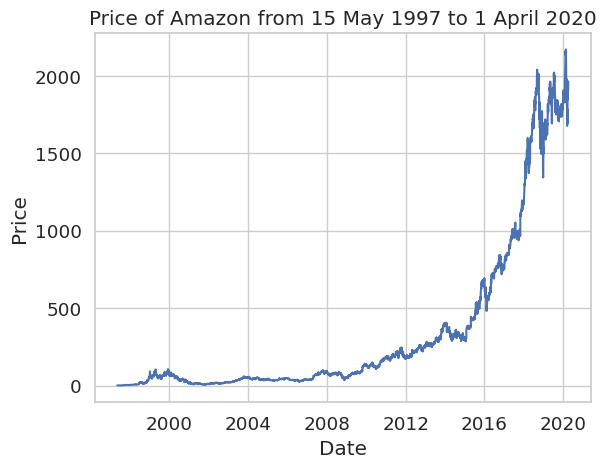

<Figure size 1200x1000 with 0 Axes>

In [ ]:
sns.lineplot(data=amzn_close, x="Date", y="Price")
plt.title("Price of Amazon from 15 May 1997 to 1 April 2020")
plt.figure(figsize=(12,10))
plt.show()

In [ ]:
# only weekdays
amzn_close['Weekday'] = amzn_close.index.day_name()
amzn_close['DayNum'] = amzn_close.index.dayofweek
amzn_close.head(20)

,Price,Weekday,DayNum
Date,,,
1997-05-15,1.958333,Thursday,3
1997-05-16,1.729167,Friday,4
1997-05-19,1.708333,Monday,0
1997-05-20,1.635417,Tuesday,1
1997-05-21,1.427083,Wednesday,2
1997-05-22,1.395833,Thursday,3
1997-05-23,1.500000,Friday,4
1997-05-27,1.583333,Tuesday,1
1997-05-28,1.531250,Wednesday,2


In [ ]:
# check weekends data
amzn_close[amzn_close['DayNum'] > 4]

,Price,Weekday,DayNum
Date,,,


In [ ]:
# drop additional columns
amzn_prices = amzn_close.drop(columns=['DayNum', 'Weekday'])
amzn_prices.head()

,Price
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


Untuk memisahkan data time series dengan window size = 5 (senin sampai jumat), kita perlu memfilter data terlebih dahulu. Namun, ketika dilakukan pengecekan, ternyata sudah tidak ada data yang mencakup weekends (sabtu & minggu). Namun, dapat dilihat bahwa data yang dilampirkan tidak mencakup weekdays secara lengkap. Dalam rentang 1 minggu, ada kemungkinan bahwa tidak ada data hari senin, ataupun hari lain yang dapat diasumsikan sebagai hari libur. Oleh karena itu, untuk mendapatkan output, akan diambil hari selasa-jumat yang menghasilkan predict hari selasa. Artinya, adanya missing value tidak mempengaruhi data & data sudah cukup baik untuk diproses lebih lanjut.



In [ ]:
# URL of the CSV file
url = "https://raw.githubusercontent.com/sharonzefanyaa/UAS-deeplearn/main/Dataset%20B/AMZN.csv"

# download the CSV file
response = requests.get(url)
csv_data = response.text

# process the CSV data
amzn_timesteps = []
amzn_price = []

csv_reader = csv.reader(csv_data.splitlines(), delimiter=",")
next(csv_reader)  # Skip the header

for line in csv_reader:
    amzn_timesteps.append(datetime.strptime(line[0], "%Y-%m-%d"))
    amzn_price.append(float(line[1]))

# view the first 10 timesteps and AMZN_price values
print(amzn_timesteps[:10])
print(amzn_price[:10])


[datetime.datetime(1997, 5, 15, 0, 0), datetime.datetime(1997, 5, 16, 0, 0), datetime.datetime(1997, 5, 19, 0, 0), datetime.datetime(1997, 5, 20, 0, 0), datetime.datetime(1997, 5, 21, 0, 0), datetime.datetime(1997, 5, 22, 0, 0), datetime.datetime(1997, 5, 23, 0, 0), datetime.datetime(1997, 5, 27, 0, 0), datetime.datetime(1997, 5, 28, 0, 0), datetime.datetime(1997, 5, 29, 0, 0)]
[2.4375, 1.96875, 1.7604166269302368, 1.7291666269302368, 1.6354166269302368, 1.4375, 1.40625, 1.5104166269302368, 1.625, 1.5416666269302368]


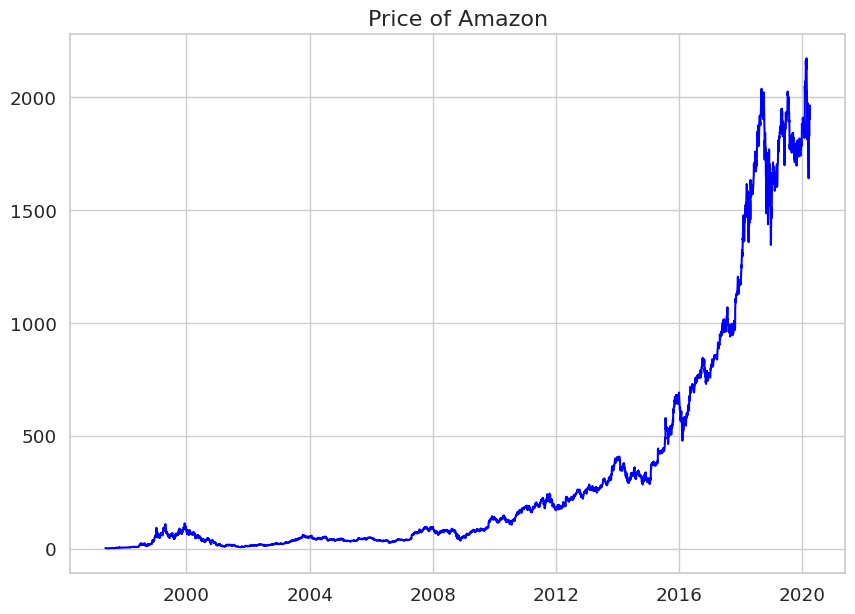

In [ ]:
# plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(amzn_timesteps, amzn_price, color = "blue")
plt.title("Price of Amazon", fontsize=16)
plt.show()

In [ ]:
# get date array
timesteps1 = amzn_prices.index.to_numpy()
prices1 = amzn_prices["Price"].to_numpy()

timesteps1[:10], prices1[:10]

(array(['1997-05-15T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
        '1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', '1997-05-27T00:00:00.000000000',
        '1997-05-28T00:00:00.000000000', '1997-05-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
        1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

In [ ]:
def basic_splits(timesteps, prices):
    train_size = int(0.8 * len(prices)) # 80% train
    val_size = int(0.1 * len(prices)) # 10% validation

    X_train, y_train = timesteps[:train_size], prices[:train_size]
    X_val, y_val = timesteps[train_size:train_size+val_size], prices[train_size:train_size+val_size]
    X_test, y_test = timesteps[train_size+val_size:], prices[train_size+val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1= basic_splits(timesteps1, prices1)
print("Train set length:", len(X_train1))
print("Validation set length:", len(X_val1))
print("Test set length:", len(X_test1))
print("Train labels length:", len(y_train1))
print("Validation labels length:", len(y_val1))
print("Test labels length:", len(y_test1))

Train set length: 4606
Validation set length: 575
Test set length: 577
Train labels length: 4606
Validation labels length: 575
Test labels length: 577


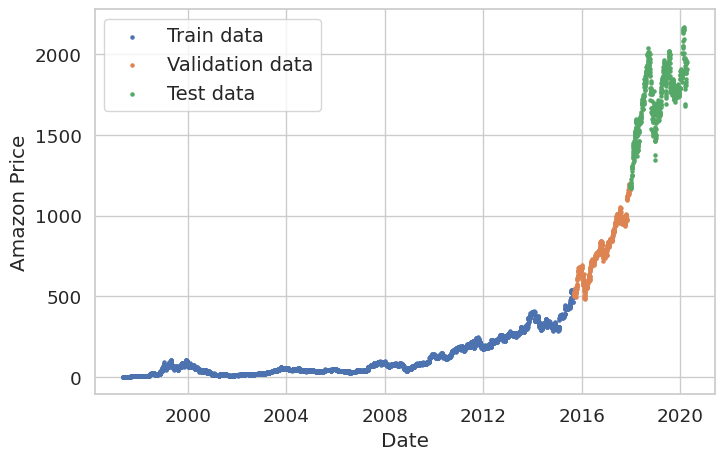

In [ ]:
# plot correctly made splits
plt.figure(figsize=(8, 5))
plt.scatter(X_train1, y_train1, s=5, label="Train data")
plt.scatter(X_val1, y_val1, s=5, label="Validation data")
plt.scatter(X_test1, y_test1, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Amazon Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
def build_windows(data, window_size, horizon):
    windows = []
    labels = []
    for i in range(len(data) - window_size - horizon + 1):
        windows.append(data[i:i+window_size])
        labels.append(data[i+window_size+horizon-1])
    return np.array(windows), np.array(labels)

In [ ]:
WINDOW_SIZE = 5
HORIZON = 1

In [ ]:
full_windows1, full_labels1 = build_windows(prices1, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows1), len(full_labels1)

(5753, 5753)

In [ ]:
# view the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows1[i]} -> Label: {full_labels1[i]}")

Window: [1.95833337 1.72916663 1.70833337 1.63541663 1.42708337] -> Label: 1.3958333730697632
Window: [1.72916663 1.70833337 1.63541663 1.42708337 1.39583337] -> Label: 1.5
Window: [1.70833337 1.63541663 1.42708337 1.39583337 1.5       ] -> Label: 1.5833333730697632


In [ ]:
# view the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows1[i-3]} -> Label: {full_labels1[i-3]}")

Window: [1902.82995605 1940.09997559 1885.83996582 1955.48999023 1900.09997559] -> Label: 1963.949951171875
Window: [1940.09997559 1885.83996582 1955.48999023 1900.09997559 1963.94995117] -> Label: 1949.719970703125
Window: [1885.83996582 1955.48999023 1900.09997559 1963.94995117 1949.7199707 ] -> Label: 1907.699951171875


In [ ]:
def train_val_test_splits(windows, labels):
    train_size = int(0.8 * len(windows)) # 80% train
    val_size = int(0.1 * len(windows)) # 10% validation

    train_windows, train_labels = windows[:train_size], labels[:train_size]
    val_windows, val_labels = windows[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_windows, test_labels = windows[train_size+val_size:], labels[train_size+val_size:]

    return train_windows, val_windows, test_windows, train_labels, val_labels, test_labels

In [ ]:
train_windows1, val_windows1, test_windows1, train_labels1, val_labels1, test_labels1= train_val_test_splits(full_windows1, full_labels1)
print("Train set length:", len(train_windows1))
print("Validation set length:", len(val_windows1))
print("Test set length:", len(test_windows1))
print("Train labels length:", len(train_labels1))
print("Validation labels length:", len(val_labels1))
print("Test labels length:", len(test_labels1))

Train set length: 4602
Validation set length: 575
Test set length: 576
Train labels length: 4602
Validation labels length: 575
Test labels length: 576


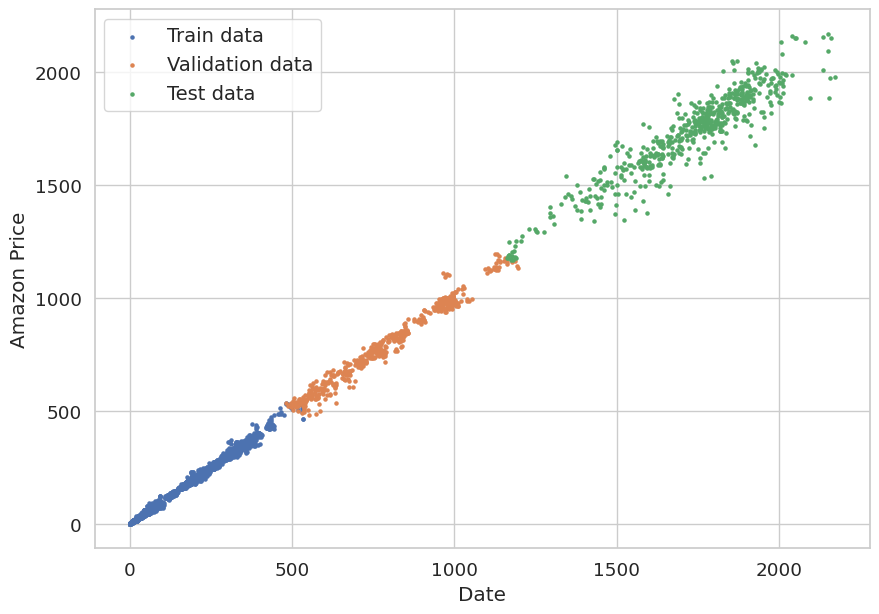

In [ ]:
# plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(train_windows1[:,0], train_labels1, s=5, label="Train data")
plt.scatter(val_windows1[:,0], val_labels1, s=5, label="Validation data")
plt.scatter(test_windows1[:,0], test_labels1, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Amazon Price")
plt.legend(fontsize=14)
plt.show()

In [ ]:
train_windows1[:5], train_labels1[:5]

(array([[1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337],
        [1.72916663, 1.70833337, 1.63541663, 1.42708337, 1.39583337],
        [1.70833337, 1.63541663, 1.42708337, 1.39583337, 1.5       ],
        [1.63541663, 1.42708337, 1.39583337, 1.5       , 1.58333337],
        [1.42708337, 1.39583337, 1.5       , 1.58333337, 1.53125   ]]),
 array([1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels1[:-HORIZON-1]), y_train1[WINDOW_SIZE:])

False

Menurut hasil pencocokkan di atas, diketahui bahwa adanya ketidakcocokan nilai pada target yang diprediksi. Hal ini dapat terjadi karena adanya pergeseran input & output ketika menggunakan windowing, yang akhirnya menyebabkan perbedaan antara target aktual dan prediksi model. Dapat dilihat bahwa jumlah training sebelum windowing (4607) tidak jauh berbeda dengan jumlah training setelah windowing (4602). Plotting yang dihasilkan setelah windowing juga memberikan kesimpulan bahwa setiap data training, validation, dan test set masih tersusun dengan baik. Oleh karena itu, menurut saya, hal ini masih dapat ditoleransi karena pergeseran yang terjadi masih termasuk pergeseran kecil dan dampaknya teradap kinerja model secara keseluruhan tidak signifikan.

##### **CISCO DATASET**

In [ ]:
# read data
df_csco = pd.read_csv('https://raw.githubusercontent.com/sharonzefanyaa/UAS-deeplearn/main/Dataset%20B/CSCO.csv',
                      parse_dates=["Date"],
                      index_col=["Date"])
df_csco.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


In [ ]:
df_csco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7589 entries, 1990-02-16 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7589 non-null   float64
 1   High       7589 non-null   float64
 2   Low        7589 non-null   float64
 3   Close      7589 non-null   float64
 4   Adj Close  7589 non-null   float64
 5   Volume     7589 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 415.0 KB


In [ ]:
df_csco.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7589.000000,7589.000000,7589.000000,7589.000000,7589.000000,7.589000e+03
mean,20.404527,20.682047,20.116294,20.399541,16.945200,5.680188e+07
std,14.915392,15.133191,14.676149,14.906589,13.253297,4.168727e+07
min,0.000000,0.072917,0.068576,0.071181,0.055102,8.064000e+05
25%,8.444445,8.583333,8.326389,8.479167,6.563846,3.245060e+07
50%,19.700001,19.937500,19.440001,19.680000,15.311988,4.898850e+07
75%,27.129999,27.410000,26.830000,27.120001,21.845076,6.822650e+07
max,81.437500,82.000000,79.062500,80.062500,61.977535,9.406368e+08


In [ ]:
df_csco.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_csco.duplicated().sum()

0

<ipython-input-233-bb75386dcbd2>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_csco[df_csco.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
<ipython-input-233-bb75386dcbd2>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_csco[df_csco.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
<ipython-input-233-bb75386dcbd2>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_csco[df_csco.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
<ipython-input-233-bb75386dcbd2>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill

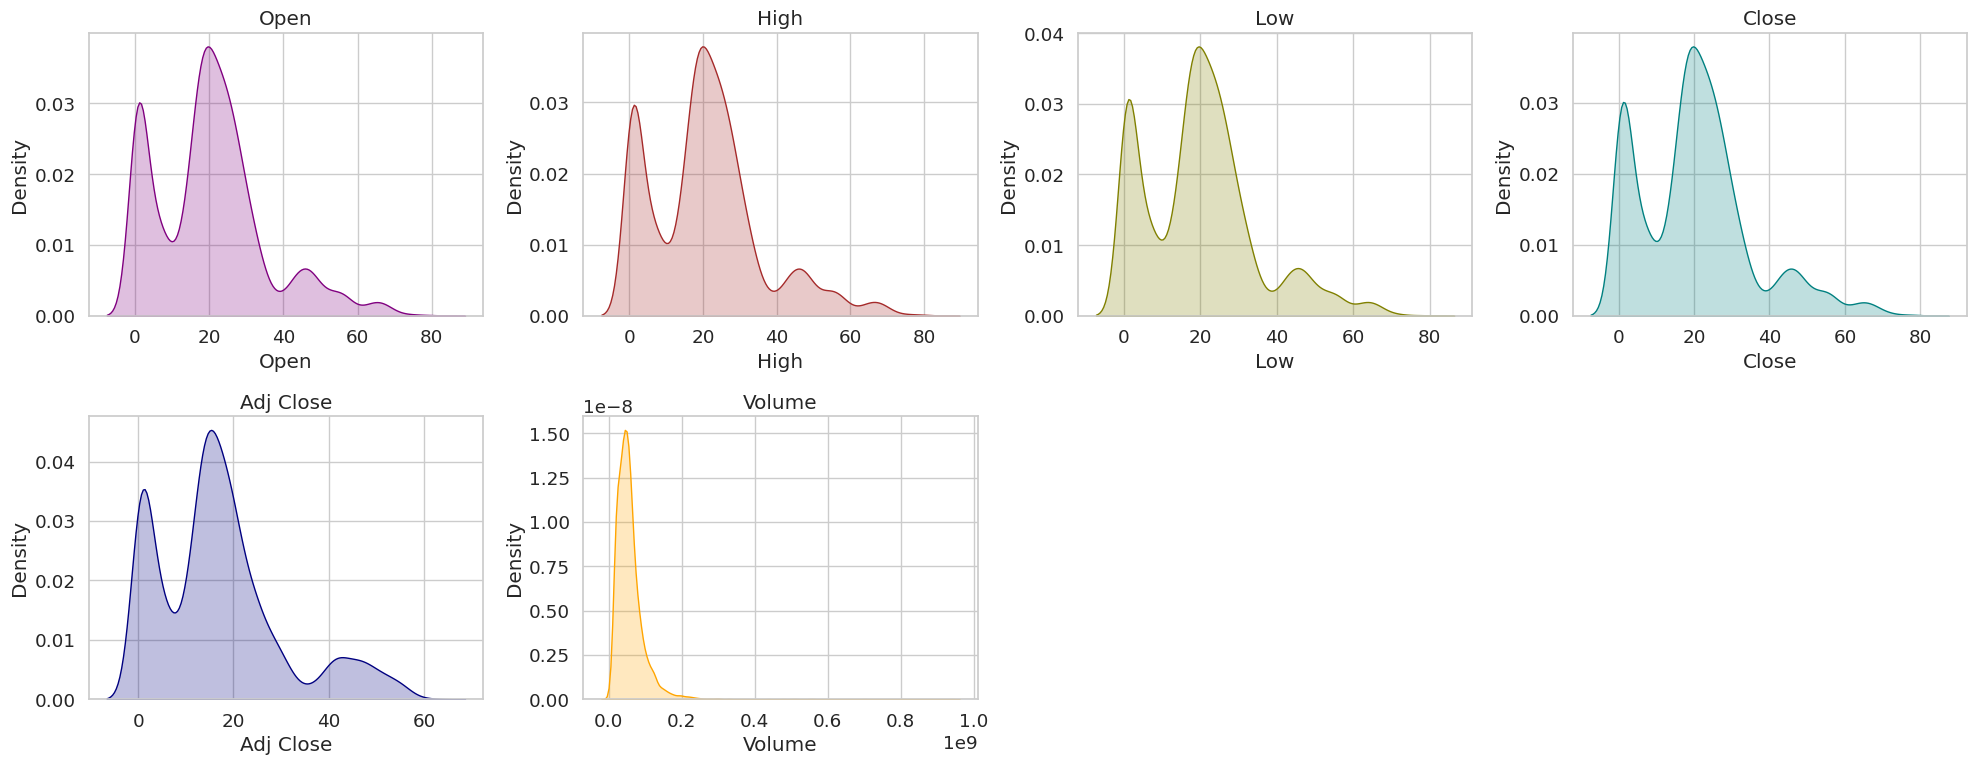

In [ ]:
# plot density plots using seaborn
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

num_cols = len(df_csco.columns)
num_rows = num_cols // 4 + 1
colors = ['purple', 'brown', 'olive', 'teal', 'navy', 'orange']

for i in range(num_cols):
    row = i // 4
    col = i % 4
    sns.kdeplot(data=df_csco[df_csco.columns[i]], ax=axes[row, col], shade=True, color=colors[i%len(colors)])
    axes[row, col].set_title(df_csco.columns[i])

# Remove empty subplots if there are any
if num_cols < 16:
    for j in range(num_cols, 16):
        row = j // 4
        col = j % 4
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

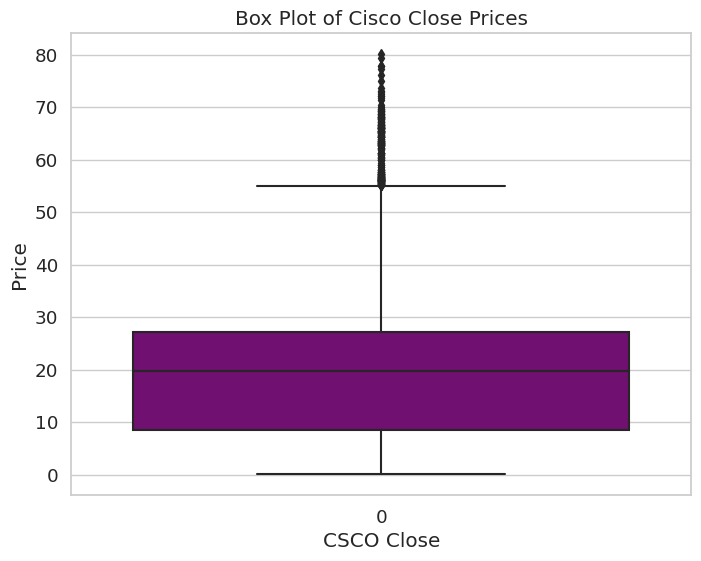

In [ ]:
# univariate analysis
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.boxplot(data=df_csco['Close'], color='purple')

plt.xlabel('CSCO Close')
plt.ylabel('Price')
plt.title('Box Plot of Cisco Close Prices')

plt.show()


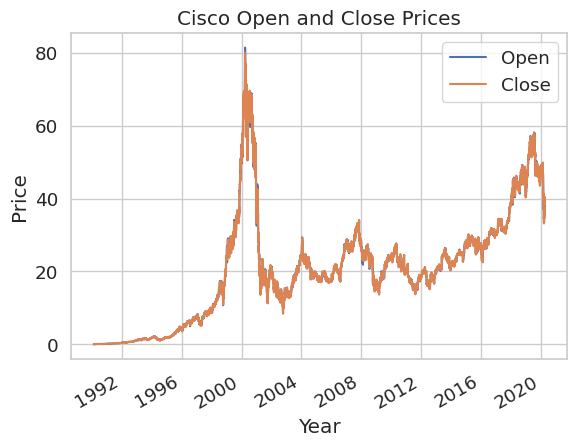

In [ ]:
# multivariate analysis
df_csco[['Open', 'Close']].plot.line()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Cisco Open and Close Prices')
plt.legend(['Open', 'Close'])
plt.show()

Dari hasil eksplorasi data sekilas di atas, diketahui bahwa data sudah siap untuk diproses lebih lanjut. Sebelumnya, atribut 'Date' sudah diubah menjadi index dengan format data datetime, tidak ada missing value maupun duplikasi data yang mencurigakan.

Selain itu, berdasarkan hasil dari density plot, diketahui bahwa semua plotnya mirip namun tidak membentuk bell curve maupun tanda-tanda skew yang pasti. Ketika atribut 'Close' dibandingkan dengan atribut 'Open', terlihat bahwa tidak ada perbedaan yang jauh antara keduanya dengan harga tertinggi sekitar tahun 2000-2004. Dapat dilihat pula bahwa ada banyak outlier pada atribut 'Close', tetapi tidak sebanyak pada dataset Amazon. Sama seperti data Amazon, ternyata semuanya ini tidak mempengaruhi pemrosesan data nanti sehingga dapat dilanjutkan dengan membuat dataframe baru yang difokuskan untuk atribut 'Close'.

In [ ]:
# only closing price
csco_close = pd.DataFrame(df_csco["Close"]).rename(columns={"Close": "Price"})
csco_close.head()

,Price
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


In [ ]:
csco_close.tail()

,Price
Date,
2020-03-26,40.580002
2020-03-27,38.820000
2020-03-30,40.320000
2020-03-31,39.310001
2020-04-01,38.330002


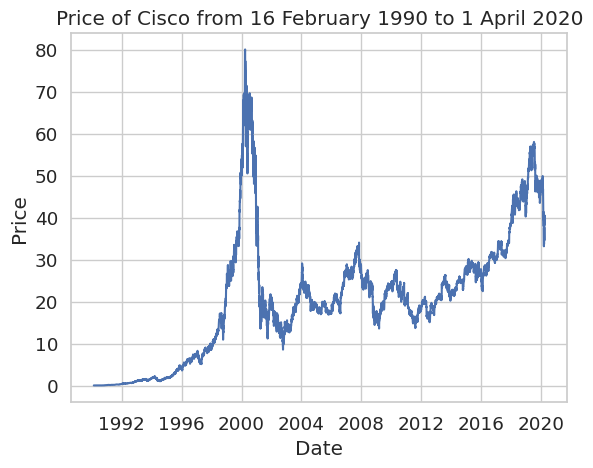

<Figure size 1200x1000 with 0 Axes>

In [ ]:
sns.lineplot(data=csco_close, x="Date", y="Price")
plt.title("Price of Cisco from 16 February 1990 to 1 April 2020")
plt.figure(figsize=(12,10))
plt.show()

In [ ]:
# only weekdays
csco_close['Weekday'] = csco_close.index.day_name()
csco_close['DayNum'] = csco_close.index.dayofweek
csco_close.head(20)

,Price,Weekday,DayNum
Date,,,
1990-02-16,0.077257,Friday,4
1990-02-20,0.079861,Tuesday,1
1990-02-21,0.078125,Wednesday,2
1990-02-22,0.078993,Thursday,3
1990-02-23,0.078559,Friday,4
1990-02-26,0.076389,Monday,0
1990-02-27,0.078125,Tuesday,1
1990-02-28,0.080729,Wednesday,2
1990-03-01,0.079861,Thursday,3


In [ ]:
# check weekends data
csco_close[csco_close['DayNum'] > 4]

,Price,Weekday,DayNum
Date,,,


In [ ]:
# drop additional columns
csco_prices = csco_close.drop(columns=['DayNum', 'Weekday'])
csco_prices.head()

,Price
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


Sama seperti dataset Amazon, Untuk memisahkan data time series dengan window size = 5 (senin sampai jumat), kita perlu memfilter data terlebih dahulu. Namun, ketika dilakukan pengecekan, ternyata sudah tidak ada data yang mencakup weekends (sabtu & minggu). Dapat dilihat bahwa data yang dilampirkan tidak mencakup weekdays secara lengkap. Dalam rentang 1 minggu, ada kemungkinan bahwa tidak ada data hari senin, ataupun hari lain yang dapat diasumsikan sebagai hari libur. Oleh karena itu, untuk mendapatkan output, akan diambil hari selasa-jumat yang menghasilkan predict hari selasa. Artinya, adanya missing value tidak mempengaruhi data & data sudah cukup baik untuk diproses lebih lanjut.

In [ ]:
# URL of the CSV file
url = "https://raw.githubusercontent.com/sharonzefanyaa/UAS-deeplearn/main/Dataset%20B/CSCO.csv"

# download the CSV file
response = requests.get(url)
csv_data = response.text

# process the CSV data
csco_timesteps = []
csco_price = []

csv_reader = csv.reader(csv_data.splitlines(), delimiter=",")
next(csv_reader)  # Skip the header

for line in csv_reader:
    csco_timesteps.append(datetime.strptime(line[0], "%Y-%m-%d"))
    csco_price.append(float(line[1]))

# view the first 10 timesteps and AMZN_price values
print(csco_timesteps[:10])
print(csco_price[:10])


[datetime.datetime(1990, 2, 16, 0, 0), datetime.datetime(1990, 2, 20, 0, 0), datetime.datetime(1990, 2, 21, 0, 0), datetime.datetime(1990, 2, 22, 0, 0), datetime.datetime(1990, 2, 23, 0, 0), datetime.datetime(1990, 2, 26, 0, 0), datetime.datetime(1990, 2, 27, 0, 0), datetime.datetime(1990, 2, 28, 0, 0), datetime.datetime(1990, 3, 1, 0, 0), datetime.datetime(1990, 3, 2, 0, 0)]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


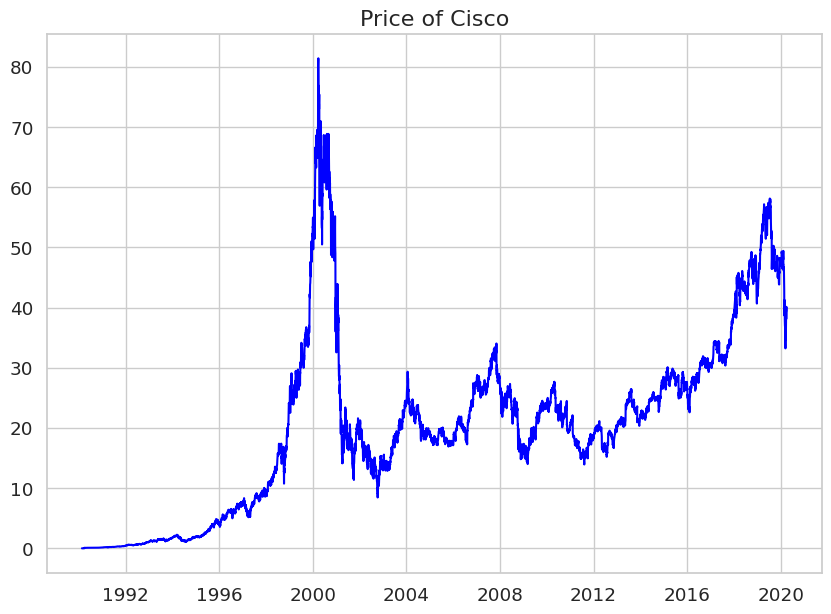

In [ ]:
# plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(csco_timesteps, csco_price, color = "blue")
plt.title("Price of Cisco", fontsize=16)
plt.show()

In [ ]:
# get date array
timesteps2 = csco_prices.index.to_numpy()
prices2 = csco_prices["Price"].to_numpy()

timesteps2[:10], prices2[:10]

(array(['1990-02-16T00:00:00.000000000', '1990-02-20T00:00:00.000000000',
        '1990-02-21T00:00:00.000000000', '1990-02-22T00:00:00.000000000',
        '1990-02-23T00:00:00.000000000', '1990-02-26T00:00:00.000000000',
        '1990-02-27T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
        '1990-03-01T00:00:00.000000000', '1990-03-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
        0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

In [ ]:
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2= basic_splits(timesteps2, prices2)
print("Train set length:", len(X_train1))
print("Validation set length:", len(X_val1))
print("Test set length:", len(X_test1))
print("Train labels length:", len(y_train1))
print("Validation labels length:", len(y_val1))
print("Test labels length:", len(y_test1))

Train set length: 4606
Validation set length: 575
Test set length: 577
Train labels length: 4606
Validation labels length: 575
Test labels length: 577


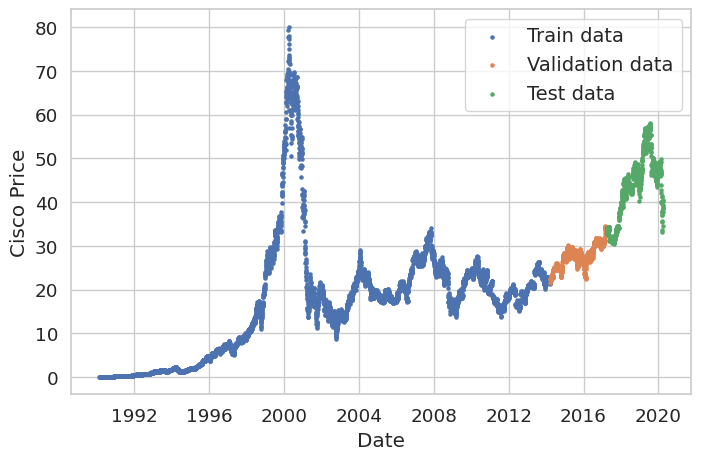

In [ ]:
# plot correctly made splits
plt.figure(figsize=(8, 5))
plt.scatter(X_train2, y_train2, s=5, label="Train data")
plt.scatter(X_val2, y_val2, s=5, label="Validation data")
plt.scatter(X_test2, y_test2, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Cisco Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
WINDOW_SIZE = 5
HORIZON = 1

In [ ]:
full_windows2, full_labels2 = build_windows(prices2, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows2), len(full_labels2)

(7584, 7584)

In [ ]:
# view the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows2[i]} -> Label: {full_labels2[i]}")

Window: [0.07725695 0.07986111 0.078125   0.07899305 0.07855903] -> Label: 0.0763888880610466
Window: [0.07986111 0.078125   0.07899305 0.07855903 0.07638889] -> Label: 0.078125
Window: [0.078125   0.07899305 0.07855903 0.07638889 0.078125  ] -> Label: 0.0807291641831398


In [ ]:
# view the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows2[i-3]} -> Label: {full_labels2[i-3]}")

Window: [34.59999847 38.59999847 37.66999817 40.58000183 38.81999969] -> Label: 40.31999969482422
Window: [38.59999847 37.66999817 40.58000183 38.81999969 40.31999969] -> Label: 39.310001373291016
Window: [37.66999817 40.58000183 38.81999969 40.31999969 39.31000137] -> Label: 38.33000183105469


In [ ]:
train_windows2, val_windows2, test_windows2, train_labels2, val_labels2, test_labels2= train_val_test_splits(full_windows2, full_labels2)
print("Train set length:", len(train_windows2))
print("Validation set length:", len(val_windows2))
print("Test set length:", len(test_windows2))
print("Train labels length:", len(train_labels2))
print("Validation labels length:", len(val_labels2))
print("Test labels length:", len(test_labels2))

Train set length: 6067
Validation set length: 758
Test set length: 759
Train labels length: 6067
Validation labels length: 758
Test labels length: 759


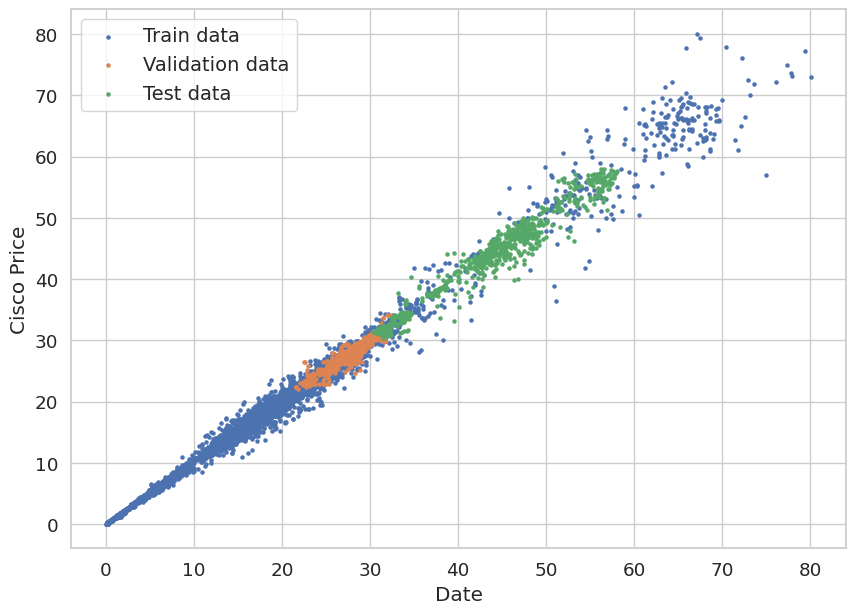

In [ ]:
# plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(train_windows2[:,0], train_labels2, s=5, label="Train data")
plt.scatter(val_windows2[:,0], val_labels2, s=5, label="Validation data")
plt.scatter(test_windows2[:,0], test_labels2, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Cisco Price")
plt.legend(fontsize=14)
plt.show()

In [ ]:
train_windows2[:5], train_labels2[:5]

(array([[0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903],
        [0.07986111, 0.078125  , 0.07899305, 0.07855903, 0.07638889],
        [0.078125  , 0.07899305, 0.07855903, 0.07638889, 0.078125  ],
        [0.07899305, 0.07855903, 0.07638889, 0.078125  , 0.08072916],
        [0.07855903, 0.07638889, 0.078125  , 0.08072916, 0.07986111]]),
 array([0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

In [ ]:
# check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels2[:-HORIZON-1]), y_train2[WINDOW_SIZE:])

False

Menurut hasil pencocokkan di atas, diketahui bahwa adanya ketidakcocokan nilai pada target yang diprediksi. Hal ini dapat terjadi karena adanya pergeseran input & output ketika menggunakan windowing, yang akhirnya menyebabkan perbedaan antara target aktual dan prediksi model. Dapat dilihat bahwa jumlah training sebelum windowing (4606)  berbeda cukup jauh dengan jumlah training setelah windowing (6067). Bahkan, melalui plotting setelah windowing, dapat dilihat juga adanya training data yang tersebar jauh dari yang seharusnya. Menurut saya, hal ini dapat cukup mengganggu karena pergeseran yang terjadi termasuk pergeseran yang dapat berdampak terhadap kinerja model secara keseluruhan tidak signifikan.

#### b. Buatlah **arsitektur baseline** dengan LSTM (units=50) dan layer akhir berupa node Perceptron dengan units=1. Activation function untuk LSTM menggunakan ReLU

##### **AMAZON DATASET**

In [ ]:
# baseline architecture
def baseline():
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
  model.add(Dense(1))

  # compile the model
  model.compile(loss='mae', optimizer='adam', metrics=['mae'])
  return model

In [ ]:
baseline1 = baseline()
baseline1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50)                10400     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_amzn = baseline1.fit(x=train_windows1,
                          y=train_labels1,
                          epochs=17,
                          batch_size=128,
                          validation_data=(val_windows1, val_labels1))

Epoch 1/17
36/36 [==============================] - 2s 16ms/step - loss: 57.0952 - mae: 57.0952 - val_loss: 64.4788 - val_mae: 64.4788
Epoch 2/17
36/36 [==============================] - 0s 9ms/step - loss: 4.1520 - mae: 4.1520 - val_loss: 14.1852 - val_mae: 14.1852
Epoch 3/17
36/36 [==============================] - 0s 9ms/step - loss: 2.7732 - mae: 2.7732 - val_loss: 16.6745 - val_mae: 16.6745
Epoch 4/17
36/36 [==============================] - 0s 9ms/step - loss: 2.4858 - mae: 2.4858 - val_loss: 20.2784 - val_mae: 20.2784
Epoch 5/17
36/36 [==============================] - 0s 9ms/step - loss: 2.2875 - mae: 2.2875 - val_loss: 13.1683 - val_mae: 13.1683
Epoch 6/17
36/36 [==============================] - 0s 9ms/step - loss: 2.1980 - mae: 2.1980 - val_loss: 15.8858 - val_mae: 15.8858
Epoch 7/17
36/36 [==============================] - 0s 11ms/step - loss: 2.4059 - mae: 2.4059 - val_loss: 17.1418 - val_mae: 17.1418
Epoch 8/17
36/36 [==============================] - 0s 9ms/step - loss: 

In [ ]:
# evaluate the model on the test set
test_loss1 = baseline1.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss1)

18/18 [==============================] - 0s 4ms/step - loss: 32.7511 - mae: 32.7511
Test Loss: [32.75110626220703, 32.75110626220703]


In [ ]:
# predict on the test set
basepredict1 = baseline1.predict(test_windows1)

# calculate evaluation metrics
baseline_rmse1 = np.sqrt(mean_squared_error(test_labels1, basepredict1))
baseline_mae1 = mean_absolute_error(test_labels1, basepredict1)
baseline_mape1 = mean_absolute_percentage_error(test_labels1, basepredict1)

print("Baseline Model:")
print("RMSE:", baseline_rmse1)
print("MAE:", baseline_mae1)
print("MAPE:", baseline_mape1)

18/18 [==============================] - 0s 3ms/step
Baseline Model:
RMSE: 43.69835555371634
MAE: 32.75110202365451
MAPE: 0.01903147148639942


Dalam kasus ini, meskipun nilai MAPE (0.0190) masih di bawah 10%, nilai loss & MAE yang tinggi (43.6983), serta nilai RMSE yang besar (32.7511) menunjukkan bahwa model baseline memiliki tingkat kesalahan prediksi yang tinggi. Hal ini dapat disimpulkan bahwa model tersebut mungkin belum bisa memodelkan time-series dengan baik dalam data.

##### **CISCO DATASET**

In [ ]:
# baseline architecture
baseline2 = baseline()
baseline2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 50)                10400     
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_csco = baseline2.fit(x=train_windows2,
                          y=train_labels2,
                          epochs=17,
                          batch_size=128,
                          validation_data=(val_windows2, val_labels2))

Epoch 1/17
48/48 [==============================] - 2s 15ms/step - loss: 5.7269 - mae: 5.7269 - val_loss: 0.4251 - val_mae: 0.4251
Epoch 2/17
48/48 [==============================] - 0s 8ms/step - loss: 0.6827 - mae: 0.6827 - val_loss: 0.4334 - val_mae: 0.4334
Epoch 3/17
48/48 [==============================] - 0s 8ms/step - loss: 0.5302 - mae: 0.5302 - val_loss: 0.4086 - val_mae: 0.4086
Epoch 4/17
48/48 [==============================] - 0s 8ms/step - loss: 0.4948 - mae: 0.4948 - val_loss: 0.4008 - val_mae: 0.4008
Epoch 5/17
48/48 [==============================] - 0s 10ms/step - loss: 0.4861 - mae: 0.4861 - val_loss: 0.4061 - val_mae: 0.4061
Epoch 6/17
48/48 [==============================] - 1s 11ms/step - loss: 0.4700 - mae: 0.4700 - val_loss: 0.3965 - val_mae: 0.3965
Epoch 7/17
48/48 [==============================] - 0s 9ms/step - loss: 0.4550 - mae: 0.4550 - val_loss: 0.3711 - val_mae: 0.3711
Epoch 8/17
48/48 [==============================] - 1s 16ms/step - loss: 0.4488 - mae: 

In [ ]:
# evaluate the model on the test set
test_loss2 = baseline2.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss2)

24/24 [==============================] - 0s 3ms/step - loss: 0.5646 - mae: 0.5646
Test Loss: [0.5645846128463745, 0.5645846128463745]


In [ ]:
# predict on the test set
basepredict2 = baseline2.predict(test_windows2)

# calculate evaluation metrics
baseline_rmse2 = np.sqrt(mean_squared_error(test_labels2, basepredict2))
baseline_mae2 = mean_absolute_error(test_labels2, basepredict2)
baseline_mape2 = mean_absolute_percentage_error(test_labels2, basepredict2)

print("Baseline Model:")
print("RMSE:", baseline_rmse2)
print("MAE:", baseline_mae2)
print("MAPE:", baseline_mape2)

24/24 [==============================] - 0s 2ms/step
Baseline Model:
RMSE: 0.8487290950998068
MAE: 0.5645845234786726
MAPE: 0.012920121771011641


Dari hasil yang diberikan, diketahui nilai loss dan MAE adalah 0.5645, dimana hal ini berarti lebih baik dibandingkan data Amazon karena nilainya lebih rendah. Selanjutnya, RMSE memiliki nilai 0.8487, yang juga jauh lebih kecil dibandingkan Amazon. Selain itu, pengukuran MAPE juga memiliki nilai 0.0129, dimana hal ini artinya sangat baik karena masih berada di bawah 10%. **Secara keseluruhan, dapat disimpulkan bahwa model Cisco lebih baik dibandingkan model Amazon.**

#### c. Setelah mengetahui hasil dari nomor (1c), **modifikasi arsitektur** pada nomor 1c untuk mendapatkan unjuk kerja yang optimal (kalian dapat menambahkan atau mengurangi arsitektur tersebut, atau mengganti hyperparameter, atau menggunakan tuning pada hyperparameter). Jelaskan alasan kalian untuk menggunakan pendekatan yang kalian pilih.

##### **Amazon Dataset**

###### 1. **Menambah jumlah lapisan LSTM.** Hal ini saya lakukan karena menurut saya data Amazon memiliki tingkat kekompleksan yang tinggi (dilihat pada boxplot ada banyak outlier), sehingga menambah jumlah lapisan LSTM dapat membantu model untuk mempelajari representasi yang lebih baik.

In [ ]:
def add_layer():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))

    # compile the model
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

amzn1 = add_layer()
amzn1.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_27 (LSTM)              (None, 50)                20200     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1_amzn = amzn1.fit(x=train_windows1,
                        y=train_labels1,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows1, val_labels1))

Epoch 1/17
36/36 [==============================] - 4s 27ms/step - loss: 41.9588 - mae: 41.9588 - val_loss: 16.2973 - val_mae: 16.2973
Epoch 2/17
36/36 [==============================] - 1s 14ms/step - loss: 3.6153 - mae: 3.6153 - val_loss: 14.5528 - val_mae: 14.5528
Epoch 3/17
36/36 [==============================] - 1s 14ms/step - loss: 3.3319 - mae: 3.3319 - val_loss: 22.9208 - val_mae: 22.9208
Epoch 4/17
36/36 [==============================] - 1s 15ms/step - loss: 3.0312 - mae: 3.0312 - val_loss: 13.8795 - val_mae: 13.8795
Epoch 5/17
36/36 [==============================] - 1s 15ms/step - loss: 2.8467 - mae: 2.8467 - val_loss: 11.0995 - val_mae: 11.0995
Epoch 6/17
36/36 [==============================] - 1s 15ms/step - loss: 2.6198 - mae: 2.6198 - val_loss: 10.9427 - val_mae: 10.9427
Epoch 7/17
36/36 [==============================] - 1s 14ms/step - loss: 2.4974 - mae: 2.4974 - val_loss: 12.4243 - val_mae: 12.4243
Epoch 8/17
36/36 [==============================] - 1s 16ms/step - 

In [ ]:
# evaluate the model on the test set
test_loss_amzn1 = amzn1.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss_amzn1)

18/18 [==============================] - 0s 5ms/step - loss: 41.3802 - mae: 41.3802
Test Loss: [41.380218505859375, 41.380218505859375]


In [ ]:
# predict on the test set
amznpredict1 = amzn1.predict(test_windows1)

# calculate evaluation metrics
amzn_rmse1 = np.sqrt(mean_squared_error(test_labels1, amznpredict1))
amzn_mae1 = mean_absolute_error(test_labels1, amznpredict1)
amzn_mape1 = mean_absolute_percentage_error(test_labels1, amznpredict1)

print("Baseline Model:")
print("RMSE:", amzn_rmse1)
print("MAE:", amzn_mae1)
print("MAPE:", amzn_mape1)

18/18 [==============================] - 0s 3ms/step
Baseline Model:
RMSE: 49.43583896041899
MAE: 41.380211936102974
MAPE: 0.023964358315175915


Setelah menambahkan jumlah lapisan LSTM, diketahui adanya perubahan pada hasil RMSE (49.6983), MAE (14.3802), dan MAPE (0.0239). Dapat dilihat bahwa semua nilainya meningkat dibandingkan dengan ketika menggunakan baseline architecture. Padahal, tujuan dari modifikasi ini adalah untuk menurunkan nilai dari ketiganya. Oleh karena itu dapat disimpulkan bahwa hasil **baseline architecture masih lebih baik**.

###### 2. **Mengatur batch size & epoch.** Hal ini saya lakukan karena menurut saya menggunakan batch yang lebih besar dapat meningkatkan efisiensi komputasi, sementara menggunakan epoch yang lebih banyak dapat memberikan model kesempatan lebih untuk mempelajari pola dalam data. Namun, hal ini tetap perlu diperhatikan agar tidak terjadi overfitting.

In [ ]:
amzn2 = baseline()
amzn2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 50)                10400     
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2_amzn = amzn2.fit(x=train_windows1,
                        y=train_labels1,
                        epochs=30,
                        batch_size=64,
                        validation_data=(val_windows1, val_labels1))

Epoch 1/30
72/72 [==============================] - 2s 11ms/step - loss: 28.9888 - mae: 28.9888 - val_loss: 13.1848 - val_mae: 13.1848
Epoch 2/30
72/72 [==============================] - 1s 7ms/step - loss: 2.6991 - mae: 2.6991 - val_loss: 16.0768 - val_mae: 16.0768
Epoch 3/30
72/72 [==============================] - 0s 7ms/step - loss: 2.4693 - mae: 2.4693 - val_loss: 11.3079 - val_mae: 11.3079
Epoch 4/30
72/72 [==============================] - 0s 6ms/step - loss: 2.4945 - mae: 2.4945 - val_loss: 10.8744 - val_mae: 10.8744
Epoch 5/30
72/72 [==============================] - 0s 6ms/step - loss: 2.6413 - mae: 2.6413 - val_loss: 14.1129 - val_mae: 14.1129
Epoch 6/30
72/72 [==============================] - 0s 7ms/step - loss: 2.6710 - mae: 2.6710 - val_loss: 10.5396 - val_mae: 10.5396
Epoch 7/30
72/72 [==============================] - 0s 6ms/step - loss: 2.4590 - mae: 2.4590 - val_loss: 11.7142 - val_mae: 11.7142
Epoch 8/30
72/72 [==============================] - 1s 7ms/step - loss: 2

In [ ]:
# evaluate the model on the test set
test_loss_amzn2 = amzn2.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss_amzn2)

18/18 [==============================] - 0s 3ms/step - loss: 48.1255 - mae: 48.1255
Test Loss: [48.12553024291992, 48.12553024291992]


In [ ]:
# predict on the test set
amznpredict2 = amzn2.predict(test_windows1)

# calculate evaluation metrics
amzn_rmse2 = np.sqrt(mean_squared_error(test_labels1, amznpredict2))
amzn_mae2 = mean_absolute_error(test_labels1, amznpredict2)
amzn_mape2 = mean_absolute_percentage_error(test_labels1, amznpredict2)

print("Baseline Model:")
print("RMSE:", amzn_rmse1)
print("MAE:", amzn_mae1)
print("MAPE:", amzn_mape1)

18/18 [==============================] - 0s 4ms/step
Baseline Model:
RMSE: 49.43583896041899
MAE: 41.380211936102974
MAPE: 0.023964358315175915


Setelah menambahkan jumlah epoch & batch size, ternyata ada kesamaan nilai dengan model pertama. Hal ini dapat dilihat dari nilai RMSE (49.4358), MAE (35.836941.3802), dan MAPE (0.0239) yang benar-benar sama dengan hasil pada model ketika ditambahkan layer LSTM. Dapat dilihat bahwa semua nilainya meningkat dibandingkan dengan ketika menggunakan baseline architecture. Setelah dilakukan pengecekan kembali, ternyata total loss pada training set sudah cukup baik, namun pada test set terlihat sangat meningkat, yang berarti model mengalami overfit. Oleh karena itu dapat disimpulkan bahwa hasil **baseline architecture masih lebih baik**.

###### 3. **Menggunakan regularisasi.** Memasukkan dropout pada bobot dapat membantu mengurangi overfitting pada model karena regularisasi membantu mengendalikan kompleksitas model & mencegahnya dari menghafal training set.

In [ ]:
def add_dropout(n):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(Dropout(n))
    model.add(Dense(1))

    # compile the model
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

amzn3 = add_dropout(0.2)
amzn3.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 5, 50)             10400     
                                                                 
 dropout_5 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense_25 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3_amzn = amzn3.fit(x=train_windows1,
                        y=train_labels1,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows1, val_labels1))

Epoch 1/17
36/36 [==============================] - 3s 18ms/step - loss: 102.7105 - mae: 102.7105 - val_loss: 605.2081 - val_mae: 605.2081
Epoch 2/17
36/36 [==============================] - 0s 12ms/step - loss: 94.6312 - mae: 94.6312 - val_loss: 607.7228 - val_mae: 607.7227
Epoch 3/17
36/36 [==============================] - 1s 14ms/step - loss: 91.0884 - mae: 91.0884 - val_loss: 631.8105 - val_mae: 631.8105
Epoch 4/17
36/36 [==============================] - 0s 12ms/step - loss: 88.8366 - mae: 88.8366 - val_loss: 628.7035 - val_mae: 628.7036
Epoch 5/17
36/36 [==============================] - 0s 14ms/step - loss: 87.2337 - mae: 87.2337 - val_loss: 645.3608 - val_mae: 645.3608
Epoch 6/17
36/36 [==============================] - 0s 11ms/step - loss: 86.3015 - mae: 86.3015 - val_loss: 653.4139 - val_mae: 653.4139
Epoch 7/17
36/36 [==============================] - 0s 10ms/step - loss: 85.7826 - mae: 85.7826 - val_loss: 651.3018 - val_mae: 651.3018
Epoch 8/17
36/36 [=====================

In [ ]:
# evaluate the model on the test set
test_loss_amzn3 = amzn3.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss_amzn3)

18/18 [==============================] - 0s 3ms/step - loss: 1460.9572 - mae: 1460.9569
Test Loss: [1460.9571533203125, 1460.9569091796875]


In [ ]:
# predict on the test set
amznpredict3 = amzn3.predict(test_windows1)
amznpredict3 = amznpredict3[:, 0, :]

# calculate evaluation metrics
amzn_rmse3 = np.sqrt(mean_squared_error(test_labels1, amznpredict3))
amzn_mae3 = mean_absolute_error(test_labels1, amznpredict3)
amzn_mape3 = mean_absolute_percentage_error(test_labels1, amznpredict3)

print("Baseline Model:")
print("RMSE:", amzn_rmse3)
print("MAE:", amzn_mae3)
print("MAPE:", amzn_mape3)

18/18 [==============================] - 0s 2ms/step
Baseline Model:
RMSE: 1461.0427255735615
MAE: 1451.7950725820328
MAPE: 0.8389641571904173


Dengan menambahkan dropout, diharapkan bahwa model akan lebih realistis dan optimal dalam pemberian hasil. Namun, ternyata semua nilai meningkat secara drastis pada hasil RMSE (1461.0427), MAE (1451.7950), dan MAPE (0.8538). Namun, jika dibandingkan dengan perubahan test loss pada setiap epoch, seluruh nilai terlihat lebih konsisten, dimana artinya overfitting berhasil ditangani. Oleh karena itu dapat disimpulkan bahwa hasil **baseline architecture masih lebih baik**.

###### 4. **Menggunakan regularisasi dan menambahkan batch size & epoch.** Memasukkan dropout pada bobot dapat membantu mengurangi overfitting, tetapi hal ini memberikan hasil yang semakin buruk pada dataset. Oleh karena itu, saya ingin mencoba menggabungkannya dengan menambahkan batch size & jumlah epoch.

In [ ]:
amzn4 = add_dropout(0.5)
amzn4.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 50)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense_26 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4_amzn = amzn4.fit(x=train_windows1,
                        y=train_labels1,
                        epochs=30,
                        batch_size=64,
                        validation_data=(val_windows1, val_labels1))

Epoch 1/30
72/72 [==============================] - 3s 16ms/step - loss: 100.9748 - mae: 100.9748 - val_loss: 653.3607 - val_mae: 653.3607
Epoch 2/30
72/72 [==============================] - 1s 11ms/step - loss: 89.8078 - mae: 89.8078 - val_loss: 657.5930 - val_mae: 657.5930
Epoch 3/30
72/72 [==============================] - 1s 11ms/step - loss: 86.7074 - mae: 86.7074 - val_loss: 662.4238 - val_mae: 662.4238
Epoch 4/30
72/72 [==============================] - 1s 9ms/step - loss: 85.8658 - mae: 85.8658 - val_loss: 671.3476 - val_mae: 671.3477
Epoch 5/30
72/72 [==============================] - 1s 7ms/step - loss: 85.3327 - mae: 85.3327 - val_loss: 671.2054 - val_mae: 671.2055
Epoch 6/30
72/72 [==============================] - 0s 7ms/step - loss: 84.5952 - mae: 84.5952 - val_loss: 675.9315 - val_mae: 675.9316
Epoch 7/30
72/72 [==============================] - 1s 7ms/step - loss: 84.1020 - mae: 84.1020 - val_loss: 679.6431 - val_mae: 679.6432
Epoch 8/30
72/72 [=========================

In [ ]:
# evaluate the model on the test set
test_loss_amzn4 = amzn4.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss_amzn4)

18/18 [==============================] - 0s 3ms/step - loss: 1516.0476 - mae: 1516.0476
Test Loss: [1516.047607421875, 1516.047607421875]


In [ ]:
# predict on the test set
amznpredict4 = amzn4.predict(test_windows1)
amznpredict4 = amznpredict4[:, 0, :]

# calculate evaluation metrics
amzn_rmse4 = np.sqrt(mean_squared_error(test_labels1, amznpredict4))
amzn_mae4 = mean_absolute_error(test_labels1, amznpredict4)
amzn_mape4 = mean_absolute_percentage_error(test_labels1, amznpredict4)

print("Baseline Model:")
print("RMSE:", amzn_rmse4)
print("MAE:", amzn_mae4)
print("MAPE:", amzn_mape4)

18/18 [==============================] - 0s 2ms/step
Baseline Model:
RMSE: 1521.5954236746265
MAE: 1511.9764676888783
MAPE: 0.8737299170364149


Setelah menambahkan dropout, batch size, dan jumlah epoch, ternyata perubahan pada hasil RMSE (1521.5954), MAE (1511.9764), dan MAPE (0.8737) menjadi semakin buruk. Dibandingkan ketika hanya ditambahkannya dropout, ternyata hasilnya lebih stabil model dengan penambahan dropout, batch size, dan epoch. Namun, hasil yang diperoleh semakin meningkat dan tidak memberikan adanya kecocokan model pada data. Oleh karena itu dapat disimpulkan bahwa hasil **baseline architecture masih lebih baik**.

###### 5. **Mengubah learning rate.** Tujuan saya memberikan learning rate adalah untuk menghindari divergensi (tidak konvergen), mencapai local optimum yang lebih baik, dan agar dapat menyesuaikan pembelajaran pada data.

In [ ]:
def baseline_lr(learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))

    # compile the model with customized learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model

amzn5 = baseline_lr(learning_rate=0.001)
amzn5.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 50)                10400     
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5_amzn = amzn5.fit(x=train_windows1,
                        y=train_labels1,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows1, val_labels1))

Epoch 1/17
36/36 [==============================] - 4s 17ms/step - loss: 101.5667 - mae: 101.5667 - val_loss: 235.6053 - val_mae: 235.6053
Epoch 2/17
36/36 [==============================] - 0s 10ms/step - loss: 8.6187 - mae: 8.6187 - val_loss: 16.8469 - val_mae: 16.8469
Epoch 3/17
36/36 [==============================] - 0s 9ms/step - loss: 3.2071 - mae: 3.2071 - val_loss: 19.0218 - val_mae: 19.0218
Epoch 4/17
36/36 [==============================] - 0s 10ms/step - loss: 2.7731 - mae: 2.7731 - val_loss: 13.4542 - val_mae: 13.4542
Epoch 5/17
36/36 [==============================] - 0s 9ms/step - loss: 2.5753 - mae: 2.5753 - val_loss: 12.6006 - val_mae: 12.6006
Epoch 6/17
36/36 [==============================] - 1s 15ms/step - loss: 2.4916 - mae: 2.4916 - val_loss: 20.3564 - val_mae: 20.3564
Epoch 7/17
36/36 [==============================] - 1s 18ms/step - loss: 2.3774 - mae: 2.3774 - val_loss: 11.1648 - val_mae: 11.1648
Epoch 8/17
36/36 [==============================] - 1s 16ms/step 

In [ ]:
# evaluate the model on the test set
test_loss_amzn5 = amzn5.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss_amzn5)

18/18 [==============================] - 0s 4ms/step - loss: 34.2015 - mae: 34.2015
Test Loss: [34.201541900634766, 34.201541900634766]


In [ ]:
# predict on the test set
amznpredict5 = amzn5.predict(test_windows1)

# calculate evaluation metrics
amzn_rmse5 = np.sqrt(mean_squared_error(test_labels1, amznpredict5))
amzn_mae5 = mean_absolute_error(test_labels1, amznpredict5)
amzn_mape5 = mean_absolute_percentage_error(test_labels1, amznpredict5)

print("Baseline Model:")
print("RMSE:", amzn_rmse5)
print("MAE:", amzn_mae5)
print("MAPE:", amzn_mape5)

18/18 [==============================] - 0s 4ms/step
Baseline Model:
RMSE: 47.29937416850695
MAE: 34.20154741075304
MAPE: 0.020024666598473233


Setelah menambahkan learning rate, model ternyata memberikan hasil yang lebih baik dibandingkan modifikasi model yang lainnya dengan nilai RMSE sebesar 47.2993, MAE sebesar 34.2015, dan MAPE sebesar 0.0200. Namun, jika dibandingkan dengan baseline architecture, semua nilainya meningkat dengan perubahan yang tidak jauh. Dapat dilihat juga  dalam training set bahwa perubahannya jauh lebih konsisten model baseline architecture dibandingkan model 5. Oleh karena itu dapat disimpulkan bahwa **baseline architecture adalah model terbaik**.

###### 6. **Menambahkan learning rate dan dropout.** Dikarenakan kedua pendekatan tuning ini berhasil menurunkan loss function dan mencapai konsistensi yang lebih baik, saya berharap ketika keduanya digabungkan dapat mencapai hasil yang lebih baik.

In [ ]:
def dropout_lr(learning_rate, n):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(Dropout(n))
    model.add(Dense(1))

    # compile the model with customized learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model

amzn6 = dropout_lr(learning_rate=0.001, n=0.5)
amzn6.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model6_amzn = amzn6.fit(x=train_windows1,
                        y=train_labels1,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows1, val_labels1))

Epoch 1/17
36/36 [==============================] - 3s 24ms/step - loss: 61.4877 - mae: 61.4877 - val_loss: 103.6361 - val_mae: 103.6361
Epoch 2/17
36/36 [==============================] - 0s 12ms/step - loss: 31.7134 - mae: 31.7134 - val_loss: 84.0697 - val_mae: 84.0697
Epoch 3/17
36/36 [==============================] - 0s 9ms/step - loss: 27.0453 - mae: 27.0453 - val_loss: 80.9456 - val_mae: 80.9456
Epoch 4/17
36/36 [==============================] - 0s 9ms/step - loss: 25.5381 - mae: 25.5381 - val_loss: 81.1364 - val_mae: 81.1364
Epoch 5/17
36/36 [==============================] - 0s 9ms/step - loss: 25.3816 - mae: 25.3816 - val_loss: 34.1654 - val_mae: 34.1654
Epoch 6/17
36/36 [==============================] - 0s 9ms/step - loss: 23.1789 - mae: 23.1789 - val_loss: 59.2057 - val_mae: 59.2057
Epoch 7/17
36/36 [==============================] - 0s 9ms/step - loss: 22.1886 - mae: 22.1886 - val_loss: 53.0907 - val_mae: 53.0907
Epoch 8/17
36/36 [==============================] - 0s 9ms

In [ ]:
# evaluate the model on the test set
test_loss_amzn6 = amzn6.evaluate(test_windows1, test_labels1)
print("Test Loss:", test_loss_amzn6)

18/18 [==============================] - 0s 11ms/step - loss: 96.3439 - mae: 96.3439
Test Loss: [96.34390258789062, 96.34390258789062]


In [ ]:
# predict on the test set
amznpredict6 = amzn6.predict(test_windows1)

# calculate evaluation metrics
amzn_rmse6 = np.sqrt(mean_squared_error(test_labels1, amznpredict6))
amzn_mae6 = mean_absolute_error(test_labels1, amznpredict6)
amzn_mape6 = mean_absolute_percentage_error(test_labels1, amznpredict6)

print("Baseline Model:")
print("RMSE:", amzn_rmse6)
print("MAE:", amzn_mae6)
print("MAPE:", amzn_mape6)

18/18 [==============================] - 0s 3ms/step
Baseline Model:
RMSE: 104.12436545927663
MAE: 96.34389241536458
MAPE: 0.055702719207255225


Setelah menambahkan jumlah learning rate & dropout, diketahui adanya perubahan pada hasil RMSE (104.1243), MAE (96.3438), dan MAPE (0.055). Dapat dilihat bahwa semua nilainya meningkat dibandingkan dengan ketika menggunakan baseline architecture maupun model 5 dan ternyata nilai yang dihasilkan jauh berbeda dari yang diharapkan. Oleh karena itu dapat disimpulkan bahwa hasil **baseline architecture adalah model terbaik**.

##### **Cisco Dataset**

###### 1. **Menambahkan jumlah unit pada layer LSTM.** Dengan menambahkan layer LSTM dengan jumlah unit lebih besar, saya berharap bahwa kemampuan model dapat ditingkatkan dalam menangkap pola yang kompleks dalam data time series.

In [ ]:
def add_units():
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))

    # compile the model
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

csco1 = add_units()
csco1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1_csco = csco1.fit(x=train_windows2,
                        y=train_labels2,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows2, val_labels2))

Epoch 1/17
48/48 [==============================] - 3s 28ms/step - loss: 5.8100 - mae: 5.8100 - val_loss: 0.6327 - val_mae: 0.6327
Epoch 2/17
48/48 [==============================] - 1s 26ms/step - loss: 0.7619 - mae: 0.7619 - val_loss: 0.4058 - val_mae: 0.4058
Epoch 3/17
48/48 [==============================] - 1s 23ms/step - loss: 0.5240 - mae: 0.5240 - val_loss: 0.4050 - val_mae: 0.4050
Epoch 4/17
48/48 [==============================] - 1s 16ms/step - loss: 0.4817 - mae: 0.4817 - val_loss: 0.3843 - val_mae: 0.3843
Epoch 5/17
48/48 [==============================] - 1s 16ms/step - loss: 0.4681 - mae: 0.4681 - val_loss: 0.3750 - val_mae: 0.3750
Epoch 6/17
48/48 [==============================] - 1s 16ms/step - loss: 0.4531 - mae: 0.4531 - val_loss: 0.4121 - val_mae: 0.4121
Epoch 7/17
48/48 [==============================] - 1s 17ms/step - loss: 0.4422 - mae: 0.4422 - val_loss: 0.3651 - val_mae: 0.3651
Epoch 8/17
48/48 [==============================] - 1s 14ms/step - loss: 0.4321 - m

In [ ]:
# evaluate the model on the test set
test_loss_csco1 = csco1.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss_csco1)

24/24 [==============================] - 0s 4ms/step - loss: 0.5420 - mae: 0.5420
Test Loss: [0.5419538617134094, 0.5419538617134094]


In [ ]:
# predict on the test set
cscopredict1 = csco1.predict(test_windows2)

# calculate evaluation metrics
csco_rmse1 = np.sqrt(mean_squared_error(test_labels2, cscopredict1))
csco_mae1 = mean_absolute_error(test_labels2, cscopredict1)
csco_mape1 = mean_absolute_percentage_error(test_labels2, cscopredict1)

print("Baseline Model:")
print("RMSE:", csco_rmse1)
print("MAE:", csco_mae1)
print("MAPE:", csco_mape1)

24/24 [==============================] - 0s 3ms/step
Baseline Model:
RMSE: 0.8084072728203675
MAE: 0.5419538947747472
MAPE: 0.012588246416100901


Dengan menambahkan jumlah unit pada layer LSTM, hasil dari nilai RMSE (0.8084), MAE (0.5419), dan MAPE (0.0125) terlihat berkurang. Artinya, kinerja model berhasil ditingkatkan sehingga **model 1 adalah model terbaik.**

###### 2. **Menggunakan fungsi aktivasi yang berbeda.** Dengan mengubah fungsi aktivasi ReLU menjadi fungsi aktivasi lain seperti sigmoid atau tanh, saya ingin melihat apakah perubahan dapat meningkatkan kinerja model. Dalam kasus ini, saya akan mencoba menggunakan fungsi aktivasi **tanh** karena saya ingin memperkuat sinyal pada lapisan LSTM agar dapat membantu meningkatkan kemampuan model dalam prediksi yang akurat.

In [ ]:
def baseline_tanh():
  model = Sequential()
  model.add(LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, 1)))
  model.add(Dense(1))

  # compile the model
  model.compile(loss='mae', optimizer='adam', metrics=['mae'])
  return model

csco2 = baseline_tanh()
csco2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50)                10400     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2_csco = csco2.fit(x=train_windows2,
                        y=train_labels2,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows2, val_labels2))

Epoch 1/17
48/48 [==============================] - 3s 22ms/step - loss: 15.3962 - mae: 15.3962 - val_loss: 24.6578 - val_mae: 24.6578
Epoch 2/17
48/48 [==============================] - 0s 9ms/step - loss: 11.9292 - mae: 11.9292 - val_loss: 19.2905 - val_mae: 19.2905
Epoch 3/17
48/48 [==============================] - 0s 8ms/step - loss: 8.4441 - mae: 8.4441 - val_loss: 14.1724 - val_mae: 14.1724
Epoch 4/17
48/48 [==============================] - 0s 8ms/step - loss: 5.7423 - mae: 5.7423 - val_loss: 10.9296 - val_mae: 10.9296
Epoch 5/17
48/48 [==============================] - 0s 7ms/step - loss: 4.3194 - mae: 4.3194 - val_loss: 8.6308 - val_mae: 8.6308
Epoch 6/17
48/48 [==============================] - 0s 8ms/step - loss: 3.5036 - mae: 3.5036 - val_loss: 6.8446 - val_mae: 6.8446
Epoch 7/17
48/48 [==============================] - 0s 8ms/step - loss: 2.9901 - mae: 2.9901 - val_loss: 5.4003 - val_mae: 5.4003
Epoch 8/17
48/48 [==============================] - 0s 8ms/step - loss: 2.635

In [ ]:
# evaluate the model on the test set
test_loss_csco2 = csco2.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss_csco2)

24/24 [==============================] - 0s 3ms/step - loss: 13.2190 - mae: 13.2190
Test Loss: [13.219022750854492, 13.219022750854492]


In [ ]:
# predict on the test set
cscopredict2 = csco2.predict(test_windows2)

# calculate evaluation metrics
csco_rmse2 = np.sqrt(mean_squared_error(test_labels2, cscopredict2))
csco_mae2 = mean_absolute_error(test_labels2, cscopredict2)
csco_mape2 = mean_absolute_percentage_error(test_labels2, cscopredict2)

print("Baseline Model:")
print("RMSE:", csco_rmse2)
print("MAE:", csco_mae2)
print("MAPE:", csco_mape2)

24/24 [==============================] - 1s 3ms/step
Baseline Model:
RMSE: 15.096929568676204
MAE: 13.219022218103623
MAPE: 0.2823211551843802


Setelah mengubah fungsi aktivasi ReLU menjadi tanh, diketahui hasil yang diberikan menjadi semakin buruk dengan nilai RMSE sebesar 15.0969, MAE sebesar 13.2190, dan MAPE sebesar 0.2823. Dapat dilihat bahwa semua nilainya meningkat dibandingkan dengan model-model sebelumnya. Oleh karena itu dapat disimpulkan bahwa **model 1 adalah model terbaik**.

###### 3. **Mengubah learning rate.** Saya ingin mengatur learning rate untuk melihat apakah perubahan learning rate dapat meningkatkan hasil pada model baseline architecture dan mempercepat pencapaian konvergen.

In [ ]:
csco3 = baseline_lr(learning_rate=0.001)
csco3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                10400     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3_csco = csco3.fit(x=train_windows2,
                        y=train_labels2,
                        epochs=17,
                        batch_size=128,
                        validation_data=(val_windows2, val_labels2))

Epoch 1/17
48/48 [==============================] - 2s 13ms/step - loss: 4.0743 - mae: 4.0743 - val_loss: 0.5850 - val_mae: 0.5850
Epoch 2/17
48/48 [==============================] - 0s 8ms/step - loss: 0.6929 - mae: 0.6929 - val_loss: 0.4683 - val_mae: 0.4683
Epoch 3/17
48/48 [==============================] - 0s 8ms/step - loss: 0.5186 - mae: 0.5186 - val_loss: 0.3759 - val_mae: 0.3759
Epoch 4/17
48/48 [==============================] - 0s 8ms/step - loss: 0.4595 - mae: 0.4595 - val_loss: 0.3594 - val_mae: 0.3594
Epoch 5/17
48/48 [==============================] - 0s 10ms/step - loss: 0.4278 - mae: 0.4278 - val_loss: 0.3358 - val_mae: 0.3358
Epoch 6/17
48/48 [==============================] - 0s 9ms/step - loss: 0.3993 - mae: 0.3993 - val_loss: 0.2793 - val_mae: 0.2793
Epoch 7/17
48/48 [==============================] - 0s 8ms/step - loss: 0.3925 - mae: 0.3925 - val_loss: 0.3122 - val_mae: 0.3122
Epoch 8/17
48/48 [==============================] - 0s 7ms/step - loss: 0.3930 - mae: 0.

In [ ]:
# evaluate the model on the test set
test_loss_csco3 = csco3.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss_csco3)

24/24 [==============================] - 0s 3ms/step - loss: 0.5531 - mae: 0.5531
Test Loss: [0.5530824065208435, 0.5530824065208435]


In [ ]:
# predict on the test set
cscopredict3 = csco3.predict(test_windows2)

# calculate evaluation metrics
csco_rmse3 = np.sqrt(mean_squared_error(test_labels2, cscopredict3))
csco_mae3 = mean_absolute_error(test_labels2, cscopredict3)
csco_mape3 = mean_absolute_percentage_error(test_labels2, cscopredict3)

print("Baseline Model:")
print("RMSE:", csco_rmse3)
print("MAE:", csco_mae3)
print("MAPE:", csco_mape3)

24/24 [==============================] - 0s 3ms/step
Baseline Model:
RMSE: 0.7970948700779428
MAE: 0.5530823115774763
MAPE: 0.012693498516167561


Setelah menambahkan learning rate pada model, ternyata model memberikan hasil yang sedikit lebih baik dibandingkan model 1, dimana ditambahkannya jumlah unit pada layer LSTM. Hasil dari nilai RMSE adalah 0.7970, dengan MAE sebesar 0.5530, dan MAPE sebesar 0.0126. Jika dilihat kembali, nilai MAE lebih besar dibandingkan model 1, namun nilai RMSE lebih kecil dibandingkan model 1. Saya beranggapan bahwa nilai RMSE yang semakin kecil akan semakin baik karena RMSE lebih sensitif terhadap kesalahan nilai prediksi. Oleh karena itu, **model 3 adalah model terbaik.**

###### 4. **Mengubah jumlah epoch & batch size.** Saya ingin mencoba menambahkan jumlah epoch & batch size agar dapat memberikan model lebih banyak waktu untuk belajar dan menghasilkan bobot yang lebih akurat. Selain itu, saya juga ingin mencapai keseimbangan antara kecepatan pelatihan, kinerja model, dan penggunaan sumber daya yang efisien.

In [ ]:
csco4 = baseline()
csco4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                10400     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4_csco = csco4.fit(x=train_windows2,
                        y=train_labels2,
                        epochs=30,
                        batch_size=64,
                        validation_data=(val_windows2, val_labels2))

Epoch 1/30
95/95 [==============================] - 3s 14ms/step - loss: 3.9525 - mae: 3.9525 - val_loss: 0.5516 - val_mae: 0.5516
Epoch 2/30
95/95 [==============================] - 1s 8ms/step - loss: 0.5253 - mae: 0.5253 - val_loss: 0.4141 - val_mae: 0.4141
Epoch 3/30
95/95 [==============================] - 1s 8ms/step - loss: 0.4643 - mae: 0.4643 - val_loss: 0.4095 - val_mae: 0.4095
Epoch 4/30
95/95 [==============================] - 1s 7ms/step - loss: 0.4513 - mae: 0.4513 - val_loss: 0.3980 - val_mae: 0.3980
Epoch 5/30
95/95 [==============================] - 1s 6ms/step - loss: 0.4401 - mae: 0.4401 - val_loss: 0.4780 - val_mae: 0.4780
Epoch 6/30
95/95 [==============================] - 1s 6ms/step - loss: 0.4543 - mae: 0.4543 - val_loss: 0.8146 - val_mae: 0.8146
Epoch 7/30
95/95 [==============================] - 1s 6ms/step - loss: 0.4158 - mae: 0.4158 - val_loss: 0.3527 - val_mae: 0.3527
Epoch 8/30
95/95 [==============================] - 1s 7ms/step - loss: 0.3974 - mae: 0.3

In [ ]:
test_loss_csco4 = csco4.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss_csco4)

24/24 [==============================] - 0s 3ms/step - loss: 0.5088 - mae: 0.5088
Test Loss: [0.5088255405426025, 0.5088255405426025]


In [ ]:
# predict on the test set
cscopredict4 = csco4.predict(test_windows2)

# calculate evaluation metrics
csco_rmse4 = np.sqrt(mean_squared_error(test_labels2, cscopredict4))
csco_mae4 = mean_absolute_error(test_labels2, cscopredict4)
csco_mape4 = mean_absolute_percentage_error(test_labels2, cscopredict4)

print("Baseline Model:")
print("RMSE:", csco_rmse4)
print("MAE:", csco_mae4)
print("MAPE:", csco_mape4)

24/24 [==============================] - 0s 3ms/step
Baseline Model:
RMSE: 0.7758019050191569
MAE: 0.508825520752918
MAPE: 0.011691339460381442


Setelah menambahkan jumlah epoch & batch size pada model, ternyata model memberikan hasil yang lebih baik dibandingkan model 3 (penambahan learning rate). Hasil dari nilai RMSE adalah 0.7758, dengan MAE sebesar 0.5088, dan MAPE sebesar 0.0116. Jika dilihat kembali, semua nilai mengalami penurunan menjadi nilai lebih kecil dibandingkan model 3, yang artinya performa model semakin baik. Sejauh ini, model juga tidak mengalami tanda-tanda terjadinya overfit yang signifikan. Oleh karena itu, **model 4 adalah model terbaik.**

#### d.  Lakukan **evaluasi** unjuk kerja kedua arsitektur di atas pada test set dengan mencari nilai RMSE, MAE dan MAPE. Dan berikan penjelasan mengenai hasilnya dengan rinci.

##### **Amazon Dataset**

In [ ]:
# predict on the test set
amznpredict5 = amzn5.predict(test_windows1)

# calculate evaluation metrics
amzn_rmse5 = np.sqrt(mean_squared_error(test_labels1, amznpredict5))
amzn_mae5 = mean_absolute_error(test_labels1, amznpredict5)
amzn_mape5 = mean_absolute_percentage_error(test_labels1, amznpredict5)

print("Baseline Model:")
print("RMSE:", amzn_rmse5)
print("MAE:", amzn_mae5)
print("MAPE:", amzn_mape5)

18/18 [==============================] - 0s 4ms/step
Baseline Model:
RMSE: 47.29937416850695
MAE: 34.20154741075304
MAPE: 0.020024666598473233


Setelah mencoba melakukan banyak modifikasi terhadap model dari baseline architecture Amazon, menurut saya model terbaik adalah **baseline architecture** itu sendiri. Hal ini dikarenakan model memberikan performa paling baik dan konsisten dibandingkan percobaan lainnya. Meskipun terlihat masih terjadi overfitting, namun hasil paling optimal tetap dihasilkan dari model ini.

##### **Cisco Dataset**

In [ ]:
# predict on the test set
cscopredict4 = csco4.predict(test_windows2)

# calculate evaluation metrics
csco_rmse4 = np.sqrt(mean_squared_error(test_labels2, cscopredict4))
csco_mae4 = mean_absolute_error(test_labels2, cscopredict4)
csco_mape4 = mean_absolute_percentage_error(test_labels2, cscopredict4)

print("Baseline Model:")
print("RMSE:", csco_rmse4)
print("MAE:", csco_mae4)
print("MAPE:", csco_mape4)

24/24 [==============================] - 0s 6ms/step
Baseline Model:
RMSE: 0.7758019050191569
MAE: 0.508825520752918
MAPE: 0.011691339460381442


Setelah mencoba melakukan banyak modifikasi terhadap model dari baseline architecture Cisco, menurut saya model terbaik adalah **model 4**, dimana dilakukan **penambahan jumlah epoch & batch size.** Hal ini dikarenakan model memberikan performa paling baik dan konsisten dibandingkan percobaan lainnya. Dapat dilihat juga bahwa model tidak mengalami overfitting secara signifikan.

##### **KESIMPULAN**

Dari kedua dataset di atas (Amazon & Cisco), menurut saya model yang paling baik dihasilkan oleh model Cisco. Hal ini dapat terjadi akibat data training yang kemungkinan tersebar secara merata ketika dilakukan windowing sebelumnya (dapat dilihat pada plot setelah windowing), sehingga data validation maupun testing dapat mencapai hasil yang kurang akurat karena data training kurang dipisahkan dengan baik. Namun, tidak dapat diasumsi pula bahwa data Cisco akan mencapai hasil yang lebih buruk dibandingkan data Amazon meskipun adanya pergeseran data setelah windowing. Selain itu, perbedaan hasil performa & kinerja model sangat terlihat secara drastis bahwa data Cisco memiliki hasil yang lebih baik. Oleh karena itu, menurut saya, **data Cisco masih lebih baik dibandingkan data Amazon.** Namun, pandangan saya dapat ditelusuri lebih dalam lagi pada penelitian yang selanjutnya untuk membuktikan apakah pergeseran windowing akan sangat mempengaruhi kinerja model.